In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from pathlib import Path
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)

# --- Configuration ---
DATA_DIR = Path("../data_final")
TRAIN_PATH = DATA_DIR / "vm_train.parquet"
VAL_PATH   = DATA_DIR / "vm_val.parquet"
TEST_PATH  = DATA_DIR / "vm_test.parquet"

TARGET_COL = "critical"


In [2]:
# 1. Load Data Splits
# ------------------------------------------------------------------------------
print("Loading split files...")
df_train = pl.read_parquet(TRAIN_PATH)
df_val   = pl.read_parquet(VAL_PATH)
df_test  = pl.read_parquet(TEST_PATH)

print(f"Train rows: {df_train.height}")

Loading split files...
Train rows: 632426


In [3]:
# 2. Strict Feature Selection (23 Features)
# ------------------------------------------------------------------------------

# A. Identifiers & Timing (4 features)
feat_timing = [
    "day_idx", 
    "hour_of_day",
    "ts_vm_created",      # Added
    "ts_first_vm_created" # Added
]

# B. Static VM Config & Deployment Metadata (8 features)
feat_static = [
    "vm_virtual_core_count",
    "vm_memory_gb",
    "vm_mem_per_core",
    "deployment_size",
    "log_deployment_size",
    "count_vms_created",
    "sub_first_day",
    "sub_first_hour"
]

# C. Tenant History Features (10 features)
# Derived from 04_tenant_history_features.ipynb
feat_history = [
    "hist_n_vms",
    "hist_n_critical",
    "hist_has_past",
    "hist_critical_frac",
    "hist_lifetime_mean",
    "hist_lifetime_std",
    "hist_cpu_mean_mean",
    "hist_p95_mean",
    "hist_frac_gt60_mean",
    "hist_day_night_ratio_mean"
]

# D. Categorical Features (1 feature)
feat_categorical = ["vm_category"]

# Combine all 23 features
ALL_FEATURES = feat_timing + feat_static + feat_history + feat_categorical

print(f"\n--- Feature Check ---")
print(f"Timing: {len(feat_timing)}")
print(f"Static: {len(feat_static)}")
print(f"History: {len(feat_history)}")
print(f"Categorical: {len(feat_categorical)}")
print(f"Total Features: {len(ALL_FEATURES)}")


--- Feature Check ---
Timing: 4
Static: 8
History: 10
Categorical: 1
Total Features: 23


In [4]:
# 3. Prepare Data for LightGBM
# ------------------------------------------------------------------------------
def prepare_for_lgbm(df_polars):
    # Select features + target
    df_pd = df_polars.select(ALL_FEATURES + [TARGET_COL]).to_pandas()
    
    # Separate X and y
    X = df_pd[ALL_FEATURES].copy()
    y = df_pd[TARGET_COL].values.ravel()
    
    # Cast categorical columns to 'category' dtype for LightGBM
    for cat_col in feat_categorical:
        X[cat_col] = X[cat_col].astype('category')
        
    return X, y

X_train, y_train = prepare_for_lgbm(df_train)
X_val, y_val     = prepare_for_lgbm(df_val)
X_test, y_test   = prepare_for_lgbm(df_test)

print(f"\nData Ready.")
print(f"Train Positive Rate: {y_train.mean():.2%} (Count: {y_train.sum()})")


Data Ready.
Train Positive Rate: 35.93% (Count: 227239)


In [5]:
# 4. Configure & Train LightGBM
# ------------------------------------------------------------------------------
print("\n--- Starting LightGBM Training ---")

# Calculate imbalance ratio for scale_pos_weight
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_weight = neg_count / pos_count
print(f"Scale Weight (Neg/Pos): {scale_weight:.2f}")


clf = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=1000,
    learning_rate=0.03,       # Low learning rate for better generalization
    num_leaves=31,            # Standard tree complexity
    max_depth=-1,
    scale_pos_weight=scale_weight, # Handle the ~2.6% imbalance
    random_state=42,
    n_jobs=-1,
    importance_type='gain'
)


"""
clf = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    # Remove scale_pos_weight
    is_unbalance=True,  # Let LightGBM handle it automatically
    n_estimators=1000,
    learning_rate=0.03
)
"""

# Train with Early Stopping
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=['train', 'val'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print("--- Training Complete ---")


--- Starting LightGBM Training ---
Scale Weight (Neg/Pos): 1.78
[LightGBM] [Info] Number of positive: 227239, number of negative: 405187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3563
[LightGBM] [Info] Number of data points in the train set: 632426, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.359313 -> initscore=-0.578346
[LightGBM] [Info] Start training from score -0.578346
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.84308	val's auc: 0.844092
Early stopping, best iteration is:
[127]	train's auc: 0.846019	val's auc: 0.845254
--- Training Complete ---


Best validation threshold (F1): 0.488
[Validation] threshold=0.488
              precision    recall  f1-score   support

           0      0.868     0.816     0.841     90628
           1      0.627     0.714     0.668     39377

    accuracy                          0.785    130005
   macro avg      0.748     0.765     0.754    130005
weighted avg      0.795     0.785     0.789    130005

AUC-PR: 0.7554 | AUC-ROC: 0.8453


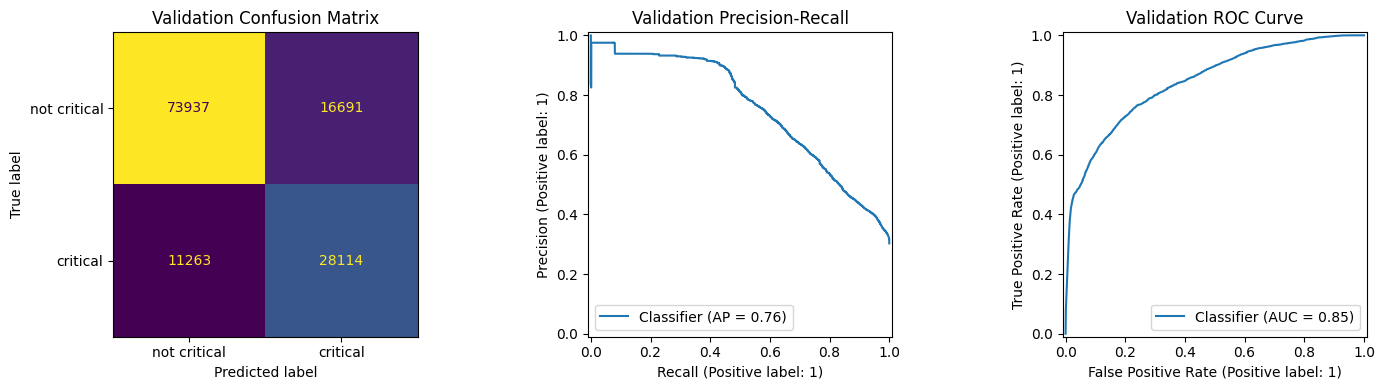

[Test] threshold=0.488
              precision    recall  f1-score   support

           0      0.852     0.755     0.800     89173
           1      0.586     0.726     0.649     42676

    accuracy                          0.745    131849
   macro avg      0.719     0.740     0.725    131849
weighted avg      0.766     0.745     0.751    131849

AUC-PR: 0.7406 | AUC-ROC: 0.8252


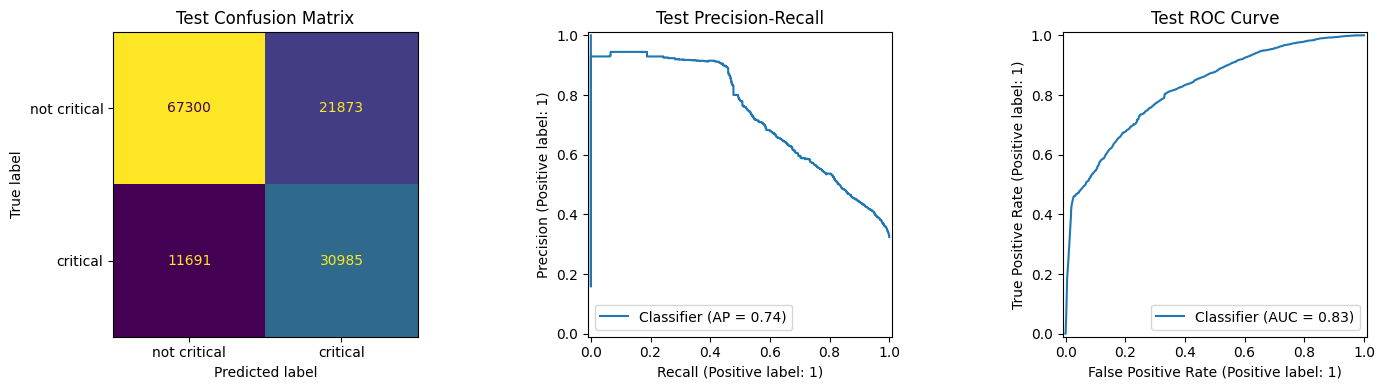

In [6]:
# 5. Evaluate on Validation/Test (PR + ROC + Confusion)
# ------------------------------------------------------------------------------

def evaluate_split(model, X, y, split_name: str, threshold: float = 0.5):
    # Print metrics + confusion matrix and show PR/ROC curves for a split.
    proba = model.predict_proba(X)[:, 1]
    preds = (proba >= threshold).astype(int)

    auc_pr = average_precision_score(y, proba)
    auc_roc = roc_auc_score(y, proba)
    cm = confusion_matrix(y, preds)

    print(f"[{split_name}] threshold={threshold:.3f}")
    print(classification_report(y, preds, digits=3, zero_division=0))
    print(f"AUC-PR: {auc_pr:.4f} | AUC-ROC: {auc_roc:.4f}")

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ConfusionMatrixDisplay(cm, display_labels=["not critical", "critical"]).plot(ax=axes[0], colorbar=False)
    axes[0].set_title(f"{split_name} Confusion Matrix")
    PrecisionRecallDisplay.from_predictions(y, proba, ax=axes[1])
    axes[1].set_title(f"{split_name} Precision-Recall")
    RocCurveDisplay.from_predictions(y, proba, ax=axes[2])
    axes[2].set_title(f"{split_name} ROC Curve")
    plt.tight_layout()
    plt.show()

    return {"auc_pr": auc_pr, "auc_roc": auc_roc, "confusion": cm.tolist()}

proba_val = clf.predict_proba(X_val)[:, 1]
candidates = np.linspace(0.01, 0.5, 200)
best_threshold = max(candidates, key=lambda t: f1_score(y_val, (proba_val >= t).astype(int)))

print(f"Best validation threshold (F1): {best_threshold:.3f}")

val_metrics = evaluate_split(clf, X_val, y_val, "Validation", threshold=best_threshold)
test_metrics = evaluate_split(clf, X_test, y_test, "Test", threshold=best_threshold)



Top 15 Features (Gain Importance):
                      Feature    Importance
15         hist_critical_frac  4.736976e+06
22                vm_category  1.067086e+05
1                 hour_of_day  9.808705e+04
7             deployment_size  9.600340e+04
4       vm_virtual_core_count  8.571734e+04
18         hist_cpu_mean_mean  7.342777e+04
2               ts_vm_created  7.266108e+04
12                 hist_n_vms  6.887672e+04
16         hist_lifetime_mean  6.701459e+04
9           count_vms_created  5.204704e+04
17          hist_lifetime_std  5.036624e+04
21  hist_day_night_ratio_mean  4.732219e+04
20        hist_frac_gt60_mean  4.143860e+04
13            hist_n_critical  3.344831e+04
19              hist_p95_mean  3.216688e+04


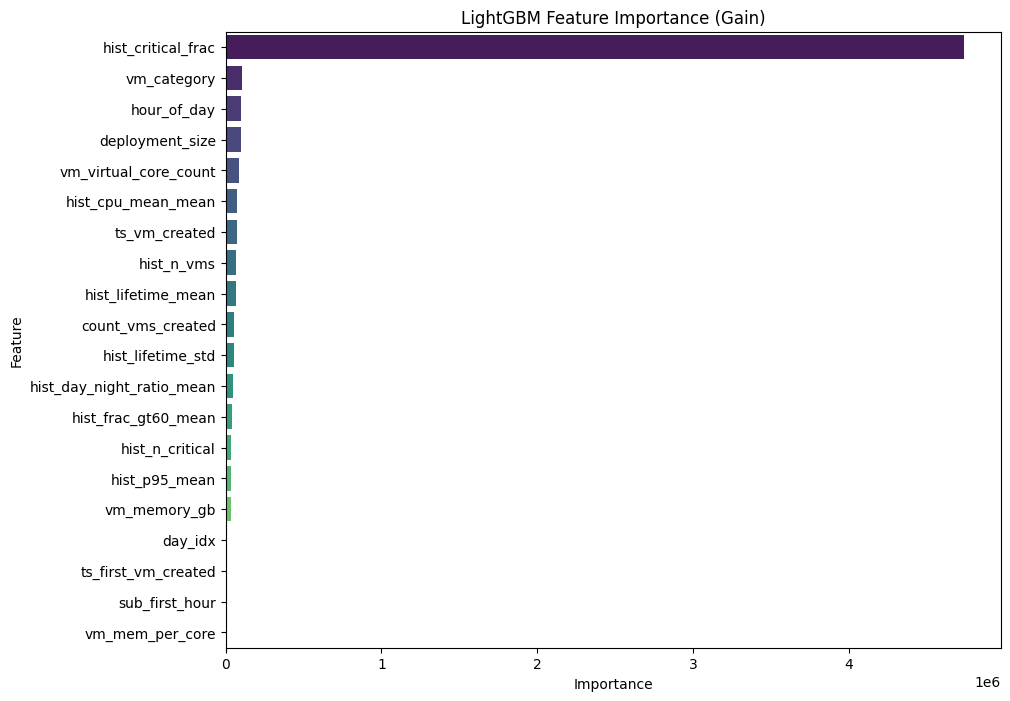

In [7]:
# 6. Feature Importance
# ------------------------------------------------------------------------------
importance = pd.DataFrame({
    'Feature': ALL_FEATURES,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 15 Features (Gain Importance):")
print(importance.head(15))

# Plot Importance
plt.figure(figsize=(10, 8))
sns.barplot(data=importance.head(20), x='Importance', y='Feature', hue='Feature', palette='viridis')
plt.title('LightGBM Feature Importance (Gain)')
plt.show()

Computing Permutation Importance on Validation Set...

Top 5 Vital Features (Val AUC impact):
                  Feature  Importance_Mean  Importance_Std
15     hist_critical_frac         0.281854        0.001081
4   vm_virtual_core_count         0.006493        0.000191
22            vm_category         0.006029        0.000149
1             hour_of_day         0.005091        0.000130
18     hist_cpu_mean_mean         0.003697        0.000158

Bottom 5 Weakest Features (Noise?):
                Feature  Importance_Mean  Importance_Std
8   log_deployment_size         0.000000        0.000000
10        sub_first_day         0.000000        0.000000
14        hist_has_past         0.000000        0.000000
12           hist_n_vms        -0.000030        0.000103
7       deployment_size        -0.000083        0.000173


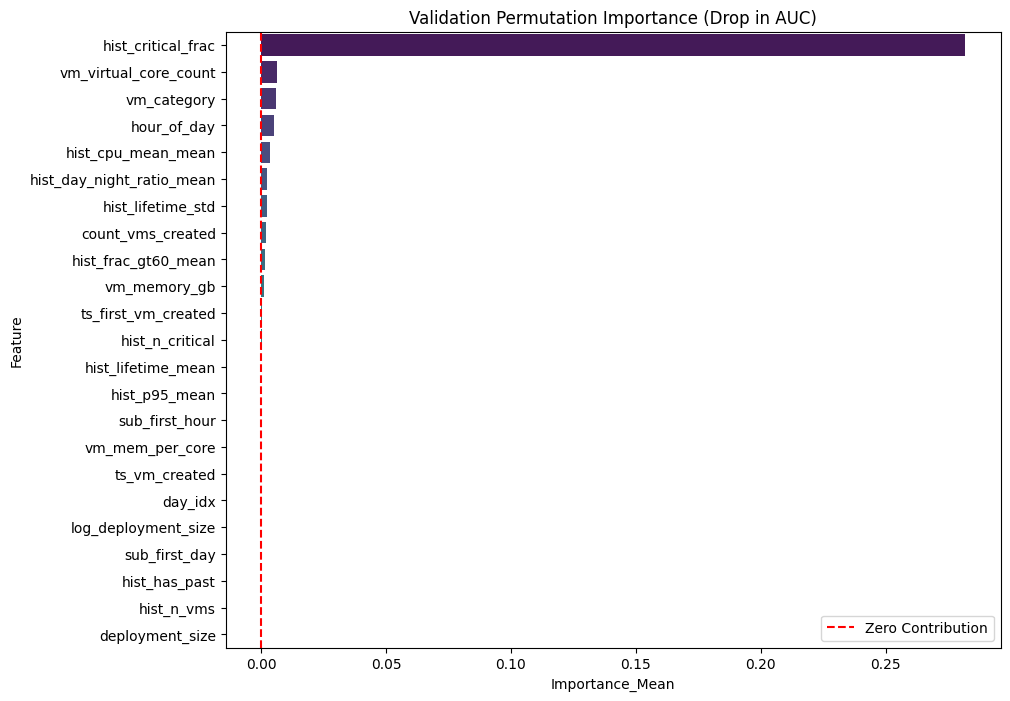

Candidates to drop (8): ['ts_vm_created', 'hist_has_past', 'vm_mem_per_core', 'day_idx', 'log_deployment_size', 'deployment_size', 'hist_n_vms', 'sub_first_day']

--- Retraining without 8 noisy features ---
[LightGBM] [Info] Number of positive: 227239, number of negative: 405187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2532
[LightGBM] [Info] Number of data points in the train set: 632426, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.359313 -> initscore=-0.578346
[LightGBM] [Info] Start training from score -0.578346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[252]	train's auc: 0.853786	val's auc: 0.848761

Original Val AUC: 0.84525
Pruned   Val AUC: 0.84876
SUCCESS: Performance improved by 0.

In [8]:
# %% [markdown]
# # ## Feature Analysis & Pruning (Permutation Importance)
# 
# We look beyond the training gain (which can be biased towards high-cardinality features) and measure how much each feature contributes to **Validation AUC**.
# 
# * **Positive Importance:** The feature is vital.
# * **Zero/Negative Importance:** The feature is noise or redundant. Dropping these often speeds up training and can improve accuracy.

# %%
from sklearn.inspection import permutation_importance

# 1. Compute Permutation Importance on Validation Data
#    Note: This is slower than built-in importance but far more accurate for pruning.
print("Computing Permutation Importance on Validation Set...")
perm_results = permutation_importance(
    clf, 
    X_val, 
    y_val, 
    n_repeats=5, 
    random_state=42, 
    n_jobs=-1,
    scoring='roc_auc'  # We optimize for AUC
)

# Organize into a DataFrame
perm_df = pd.DataFrame({
    'Feature': ALL_FEATURES,
    'Importance_Mean': perm_results.importances_mean,
    'Importance_Std': perm_results.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

# Display Top & Bottom
print("\nTop 5 Vital Features (Val AUC impact):")
print(perm_df.head(5))

print("\nBottom 5 Weakest Features (Noise?):")
print(perm_df.tail(5))

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=perm_df, x='Importance_Mean', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title("Validation Permutation Importance (Drop in AUC)")
plt.axvline(0, color='r', linestyle='--', label="Zero Contribution")
plt.legend()
plt.show()

# %% [markdown]
# ### Pruning Experiment
# Automatically identify features with $\le 0$ importance and retrain to see if we gain performance.

# %%
# 2. Identify Features to Drop
# We drop features where shuffling them actually improved or didn't change the score.
features_to_drop = perm_df[perm_df['Importance_Mean'] <= 0]['Feature'].tolist()

# Optional: You can also drop features with extremely low marginal contribution e.g. < 0.0001
# features_to_drop += perm_df[perm_df['Importance_Mean'] < 0.0001]['Feature'].tolist()

features_to_drop = list(set(features_to_drop)) # Remove duplicates

print(f"Candidates to drop ({len(features_to_drop)}): {features_to_drop}")

# %%
# 3. Retrain and Compare
if len(features_to_drop) > 0:
    print(f"\n--- Retraining without {len(features_to_drop)} noisy features ---")
    
    # Create new feature list
    pruned_features = [f for f in ALL_FEATURES if f not in features_to_drop]
    
    # Subset Data (Pandas allows direct slicing)
    X_train_pruned = X_train[pruned_features]
    X_val_pruned   = X_val[pruned_features]
    
    # Re-initialize model (same params)
    clf_pruned = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        n_estimators=1000,
        learning_rate=0.03,
        num_leaves=31,
        max_depth=-1,
        scale_pos_weight=scale_weight,
        random_state=42,
        n_jobs=-1
    )
    
    clf_pruned.fit(
        X_train_pruned, y_train,
        eval_set=[(X_train_pruned, y_train), (X_val_pruned, y_val)],
        eval_names=['train', 'val'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=0) # Silence logs
        ]
    )
    
    # Get New Validation Score
    val_proba_new = clf_pruned.predict_proba(X_val_pruned)[:, 1]
    new_auc = roc_auc_score(y_val, val_proba_new)
    
    # Compare with Baseline (from previous cells)
    print(f"\nOriginal Val AUC: {roc_auc_score(y_val, proba_val):.5f}")
    print(f"Pruned   Val AUC: {new_auc:.5f}")
    
    diff = new_auc - roc_auc_score(y_val, proba_val)
    if diff > 0:
        print(f"SUCCESS: Performance improved by {diff:.5f}")
    elif diff > -0.001:
        print(f"NEUTRAL: Performance held steady (removed {len(features_to_drop)} features). Model is simpler.")
    else:
        print(f"WARNING: Performance dropped by {diff:.5f}. Check if we removed something useful.")
else:
    print("No features identified as noise (Importance <= 0). Keeping all features.")


--- Retraining without 8 noisy features ---
Dropped features: ['ts_vm_created', 'hist_has_past', 'vm_mem_per_core', 'day_idx', 'log_deployment_size', 'deployment_size', 'hist_n_vms', 'sub_first_day']
[LightGBM] [Info] Number of positive: 227239, number of negative: 405187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2532
[LightGBM] [Info] Number of data points in the train set: 632426, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.359313 -> initscore=-0.578346
[LightGBM] [Info] Start training from score -0.578346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[252]	train's auc: 0.853786	val's auc: 0.848761

PRUNED MODEL PERFORMANCE (15 features)
[Pruned Validation] threshold=0.488
              prec

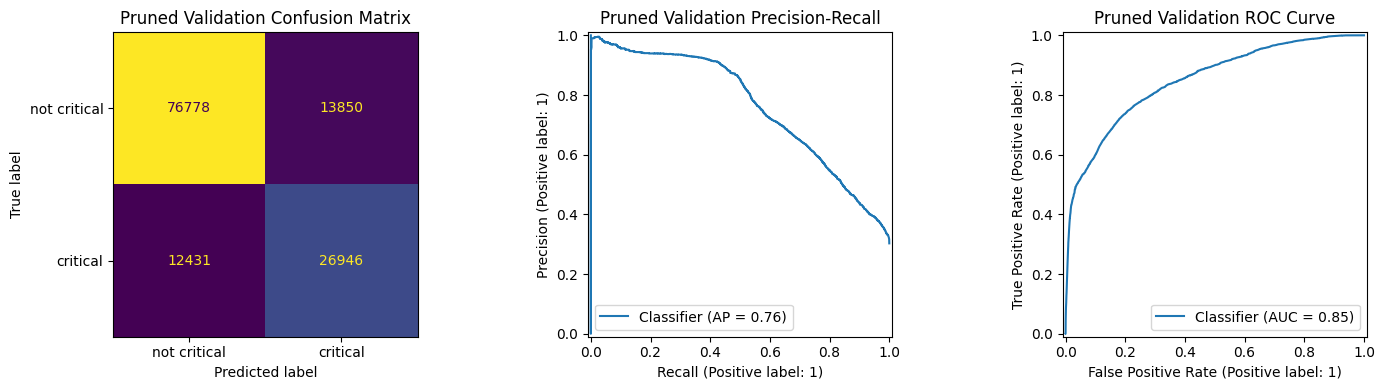

[Pruned Test] threshold=0.488
              precision    recall  f1-score   support

           0      0.833     0.806     0.819     89173
           1      0.620     0.664     0.641     42676

    accuracy                          0.760    131849
   macro avg      0.727     0.735     0.730    131849
weighted avg      0.764     0.760     0.762    131849

AUC-PR: 0.7339 | AUC-ROC: 0.8103


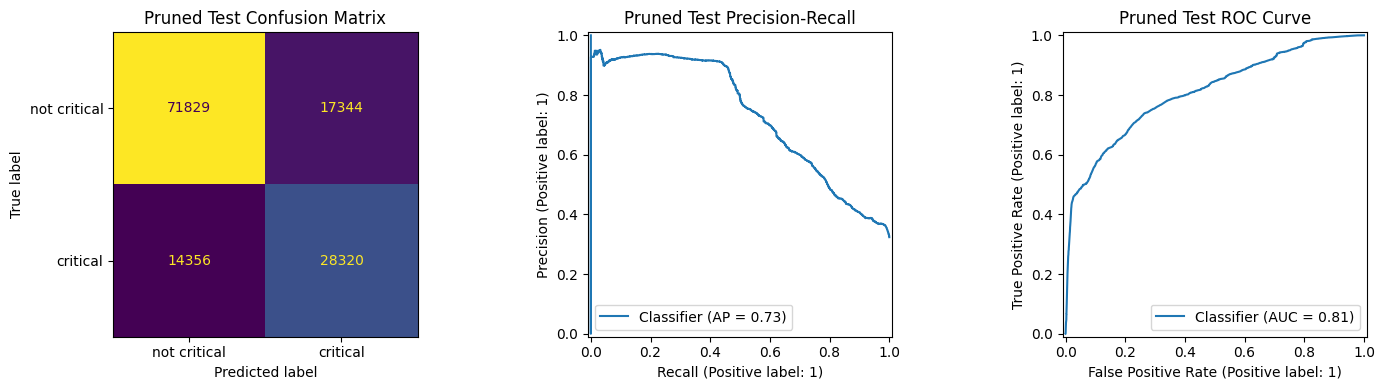

In [9]:
# %% [markdown]
# ### 3. Retrain & Evaluate with Detailed Statistics
# 
# We remove the identified noisy features and retrain the model. 
# Then, we use the `evaluate_split` function to see exactly how Precision, Recall, and AUC changed.

# %%
if len(features_to_drop) > 0:
    print(f"\n--- Retraining without {len(features_to_drop)} noisy features ---")
    print(f"Dropped features: {features_to_drop}")
    
    # 1. Create new feature lists
    pruned_features = [f for f in ALL_FEATURES if f not in features_to_drop]
    
    # 2. Subset Data
    X_train_pruned = X_train[pruned_features]
    X_val_pruned   = X_val[pruned_features]
    X_test_pruned  = X_test[pruned_features]
    
    # 3. Re-initialize and Fit
    clf_pruned = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        n_estimators=1000,
        learning_rate=0.03,
        num_leaves=31,
        max_depth=-1,
        scale_pos_weight=scale_weight,
        random_state=42,
        n_jobs=-1
    )
    
    clf_pruned.fit(
        X_train_pruned, y_train,
        eval_set=[(X_train_pruned, y_train), (X_val_pruned, y_val)],
        eval_names=['train', 'val'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=0) # Silence logs
        ]
    )
    
    # 4. Detailed Evaluation
    # We use the same 'best_threshold' calculated for the original model to make a fair comparison
    print("\n" + "="*40)
    print(f"PRUNED MODEL PERFORMANCE ({len(pruned_features)} features)")
    print("="*40)
    
    # Evaluate on Validation
    val_pruned_metrics = evaluate_split(
        clf_pruned, 
        X_val_pruned, 
        y_val, 
        "Pruned Validation", 
        threshold=best_threshold
    )
    
    # Evaluate on Test
    test_pruned_metrics = evaluate_split(
        clf_pruned, 
        X_test_pruned, 
        y_test, 
        "Pruned Test", 
        threshold=best_threshold
    )
    
else:
    print("No features identified for dropping based on the importance threshold.")